# Paper Title : A Neural Algorithm of Artistic Style
- Authors: Leon A. Gatys, Alexander S. Ecker, Matthias Bethge
- Gatys, L. A., Ecker, A. S., & Bethge, M. (2015). A Neural Algorithm of Artistic Style. ArXiv. https://arxiv.org/abs/1508.06576

In [4]:
class Config:
    content_image = None
    style_image = None
    style_image2 = None
    content_layers=['block5_conv2']
    style_layers=['block1_conv1',
                 'block2_conv1',
                 'block3_conv1',
                 'block4_conv1',
                 'block5_conv1']
    style_weight = 0.5
    content_weight = 10
    total_variation_weight = 0.004
    max_dim = 512
    epochs = 1000

In [5]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.applications as app
import time
import IPython.display as display
from tensorflow.keras.models import load_model, Model
from PIL import Image
from tqdm import tqdm
from typing import Dict, List

In [6]:
'''
Class to process images operation include loading images, 
normalization, denormalization and show images
'''
class ImageProcessor:
    def load_image(self, image_path: str, max_dim=512, normalize=False):
        img = Image.open(image_path)
        img = img.convert("RGB")
        img.thumbnail([max_dim, max_dim])
        img = np.array(img, dtype=np.float32)
        if normalize:
            img = img / 255.0
        img = np.expand_dims(img, axis=0)
        return img
        
    def deprocess_image(self, img: np.array):
        img = 255 * img
        return np.array(img, np.uint8)

    def array_to_img(self, array: np.array, deprocessing=False):
        if deprocessing:
            array = self.deprocess_image(array)
        if np.ndim(array) > 3:
            assert array.shape[0] == 1
            array = array[0]
        return Image.fromarray(array)
        
    def show(self, img: np.array, deprocessing=False):
        image = self.array_to_img(img, deprocessing)
        display.display(image)

In [7]:
class FeatureModel:
    def __init__(self, feat_layers_name: Dict[str, List[str]], model_name="vgg19"):
        if not("style" in feat_layers_name.keys() or "content" in feat_layers_name.keys()):
            raise Exception("Feature layers name dict should have 'style' and 'content' list")
            
        if model_name == "vgg16":
            feature_model = app.vgg16.VGG16(weights='imagenet', include_top=False)
            preprocess_fn = app.vgg16.preprocess_input
        elif model_name == "vgg19":
            feature_model = app.vgg19.VGG19(weights='imagenet', include_top=False)
            preprocess_fn = app.vgg19.preprocess_input
        else:
            feature_model = None
            preprocess_fn = None
            raise Exception(f"{model_name} not defined choices are ['vgg16', 'vgg19']")
            
        feature_model.trainable = False
        style_features = feat_layers_name["style"]
        content_features = feat_layers_name["content"]
        layer_names = style_features + content_features
        outputs = [feature_model.get_layer(name).output for name in layer_names]
        new_model = Model(inputs=feature_model.input, outputs=outputs, name="feature_model")
        del feature_model
        self.model = new_model
        self.preprocess_input = preprocess_fn
        self.style_features = style_features
        self.content_features = content_features

    def summary(self):
        self.model.summary()

    def __call__(self, inputs):
        inputs = inputs*255.0
        preprocessed_input = self.preprocess_input(inputs)
        outputs = self.model(preprocessed_input)
        style_length = len(self.style_features)
        style_output, content_output = outputs[:style_length], outputs[style_length:]
        content_dict = {name:value 
                        for name, value in zip(self.content_features, content_output)}
        style_dict = {name:value 
                      for name, value in zip(self.style_features, style_output)}
        return {'content':content_dict, 'style':style_dict}

In [8]:
class NSTStep:
    def __init__(self, content_image: np.array, 
                 style_image: np.array,
                 style_image2: np.array,
                 feature_model: FeatureModel,
                 optimizer: tf.keras.optimizers, 
                 content_weight: float, 
                 style_weight: float,
                 total_variation_weight: float):
        self.feature_model = feature_model
        self.optimizer = optimizer
        self.alpha = content_weight
        self.beta = style_weight
        self.gamma = total_variation_weight
        self.nst_loss = NSTLoss(self.alpha, self.beta)
        self.content_feats = feature_model(content_image)["content"]
        self.style_feats1 = feature_model(style_image)["style"]
        self.style_feats2 = feature_model(style_image2)["style"]
        self.style_feats = [self.style_feats1, self.style_feats2]
        
        
    def __call__(self, gen_image):
        with tf.GradientTape() as tape:
            outputs = self.feature_model(gen_image)
            loss = self.nst_loss(outputs, self.content_feats, self.style_feats)
            loss += self.gamma * tf.image.total_variation(gen_image)
        grad = tape.gradient(loss, gen_image)
        self.optimizer.apply_gradients([(grad, gen_image)])
        return tf.clip_by_value(gen_image, clip_value_min=0.0, clip_value_max=1.0), loss

In [15]:
class NSTLoss:
    def __init__(self, content_weight=1, style_weight=1):
        self.alpha = content_weight
        self.beta = style_weight
        
    # def content_loss(self, y_pred_list, y_content_list):
    #     total_loss = 0
    #     num_elements = len(y_pred_list)
        
    #     for y_pred, y_content in zip(y_pred_list, y_content_list):
    #         total_loss += tf.reduce_mean(tf.abs(y_pred - y_content))
    
    #     return total_loss / num_elements

    def content_loss(self, y_pred, y_content):
        return tf.reduce_mean(tf.square(y_pred - y_content))


    def __gram_matrix(self, x):
        gram=tf.linalg.einsum('bijc,bijd->bcd', x, x)
        return gram/tf.cast(x.shape[1]*x.shape[2], tf.float32)

    # def style_loss(self, y_pred, y_style):
    #     return tf.reduce_mean(tf.square(self.__gram_matrix(y_pred) - 
    #                                     self.__gram_matrix(y_style)))
    
    def style_loss(self, y_pred, y_style_list):
        total_loss = 0
        num_elements = len(y_style_list)

        gamm_ratio = [0.2, 0.8]

        assert sum(gamm_ratio) == 1.0
        
        for i, y_style in enumerate(y_style_list):
            gram_pred = self.__gram_matrix(y_pred)
            gram_style = self.__gram_matrix(y_style)
            total_loss += gamm_ratio[i] * tf.reduce_mean(tf.square(gram_pred - gram_style))
    
        return total_loss #/ num_elements

        
    def __call__(self, y_pred, y_content, y_style_list):
        pred_content= y_pred["content"]
        pred_style= y_pred["style"]
        content_loss = tf.add_n([self.content_loss(pred_content[name], y_content[name]) 
                                 for name in pred_content.keys()])/len(pred_content)
        style_loss = tf.add_n([self.style_loss(pred_style[name], [y_style_list[0][name], y_style_list[1][name]]) 
                               for name in pred_style.keys()])/len(pred_style)
        return (self.alpha * content_loss) + (self.beta * style_loss)

In [10]:
def generate_styled_image(config, 
                          image_processor, 
                          feature_model, 
                          optimizer,  
                          show_images=True, 
                          verbose=100):
    style_image = image_processor.load_image(config.style_image, max_dim=config.max_dim, normalize=True)
    style_image2 = image_processor.load_image(config.style_image2, max_dim=config.max_dim, normalize=True)
    content_image = image_processor.load_image(config.content_image, max_dim=config.max_dim, normalize=True)
    if show_images:
        print("Style Image")
        image_processor.show(style_image, deprocessing=True)
        print("Style Image2")
        image_processor.show(style_image2, deprocessing=True)
        print("Content Image")
        image_processor.show(content_image, deprocessing=True)
    
    nst_step = NSTStep(content_image=content_image, 
                       style_image=style_image,
                       style_image2=style_image2, 
                       feature_model=feature_model, 
                       optimizer=optimizer,
                       content_weight=config.content_weight,
                       style_weight=config.style_weight,
                       total_variation_weight=config.total_variation_weight
                      )
    
    gen_image = tf.Variable(content_image, dtype=tf.float32)
    losses = []
    counter = 0
    start_time = time.time()
    with tqdm(total=config.epochs) as pbar:
        for epoch in range(config.epochs):
            ugen, curr_loss = nst_step(gen_image)
            gen_image.assign(ugen)
            losses.append(curr_loss)
            pbar.update(1)
            counter += 1
            if counter > verbose:
                counter = 0
                print(f"Epoch: {epoch+1} Loss: {tf.reduce_mean(curr_loss).numpy()}")
    end_time = time.time()
    print(f"Image successfully generated in {end_time-start_time:.1f} sec")
    if show_images:
        print("Style Image")
        image_processor.show(style_image, deprocessing=True)
        print("Style Image2")
        image_processor.show(style_image2, deprocessing=True)
        print("Content Image")
        image_processor.show(content_image, deprocessing=True)
        print("Output Image")
        image_processor.show(gen_image.numpy(), deprocessing=True)
    return image_processor.array_to_img(gen_image.numpy(), deprocessing=True)

In [11]:
config = Config()
image_processor = ImageProcessor()

In [12]:
feature_model = FeatureModel({"content": config.content_layers, 
                              "style": config.style_layers},
                             model_name = "vgg19"
                            )
feature_model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "feature_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 15,304,768 (58.38 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 15,304,768 (58.38 MB)

Style Image


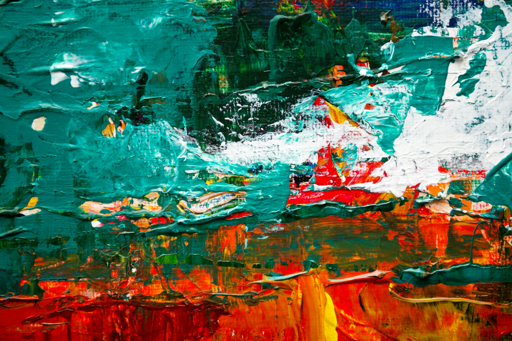

Style Image2


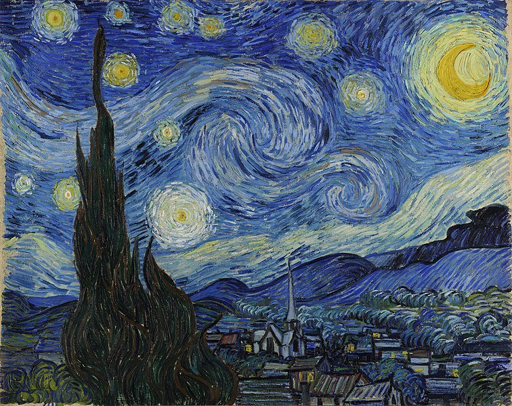

Content Image


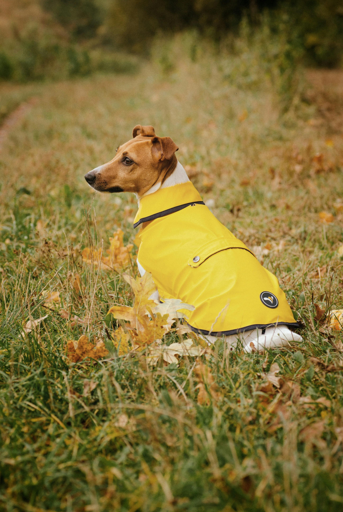

 10%|█         | 102/1000 [00:09<01:21, 11.08it/s]

Epoch: 101 Loss: 94015640.0


 20%|██        | 204/1000 [00:18<01:12, 10.98it/s]

Epoch: 202 Loss: 90200432.0


 30%|███       | 304/1000 [00:27<01:02, 11.15it/s]

Epoch: 303 Loss: 88834400.0


 41%|████      | 406/1000 [00:36<00:53, 11.10it/s]

Epoch: 404 Loss: 88270528.0


 51%|█████     | 506/1000 [00:45<00:43, 11.25it/s]

Epoch: 505 Loss: 87987112.0


 61%|██████    | 608/1000 [00:54<00:35, 11.12it/s]

Epoch: 606 Loss: 87824064.0


 71%|███████   | 708/1000 [01:03<00:26, 11.15it/s]

Epoch: 707 Loss: 87720360.0


 81%|████████  | 810/1000 [01:12<00:16, 11.26it/s]

Epoch: 808 Loss: 87649928.0


 91%|█████████ | 910/1000 [01:21<00:08, 11.08it/s]

Epoch: 909 Loss: 87598072.0


100%|██████████| 1000/1000 [01:29<00:00, 11.12it/s]


Image successfully generated in 89.9 sec
Style Image


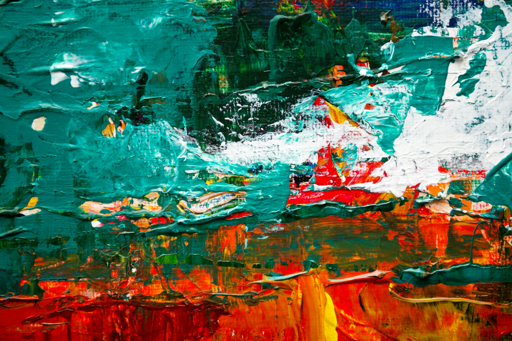

Style Image2


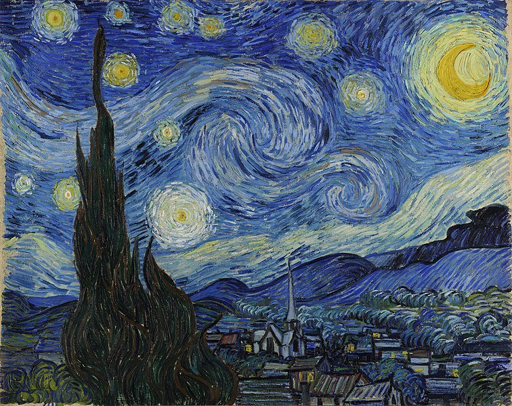

Content Image


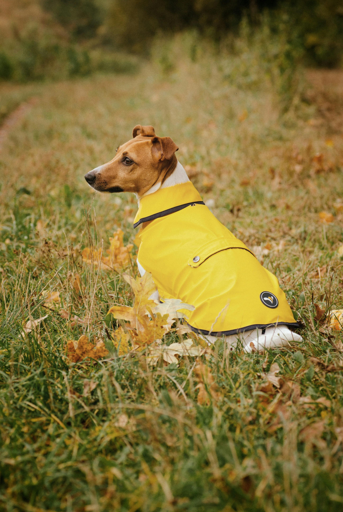

Output Image


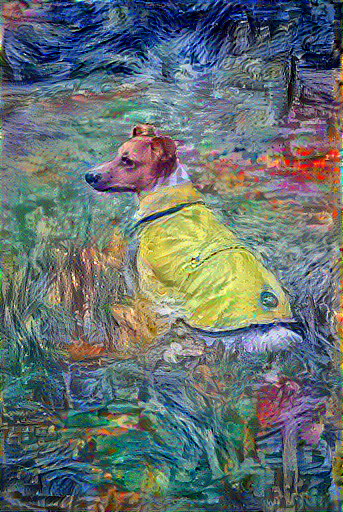

In [19]:
output_image_name = f"/kaggle/working/image_content_0.2-0.8-2_style1_8_st{config.style_weight}_cnt{config.content_weight}_tvw{config.total_variation_weight}.jpg"

optimizer = tf.optimizers.Adam(learning_rate=1e-2, beta_1=0.99, epsilon=1e-1)
styled_output = generate_styled_image(config=config,
                                      image_processor=image_processor,
                                      feature_model=feature_model,
                                      optimizer=optimizer)
styled_output.save(output_image_name)